# Toy example

Original notebook by Alexander Held, edited for the MadMiner repository by Johann Brehmer, Irina Espejo, Felix Kling, and Kyle Cranmer 2018-2019.

In this notebook, we use a simple toy example to demonstrate the machine learning and inference algorithms in MadMiner. This allows us to skip many of the more technical steps, and there's no dependency on MadGraph, Pythia, or Delphes.

What this tutorial does not do, is explaining the inference methods. To understand what's happening, please have a look at ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013), which will explain the basic idea in just a few pages. If you really want to get down to the dirty details, ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020) has you covered.

## Preparations

In [1]:
import os
import logging
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

%matplotlib inline

from madminer.ml import ParameterizedRatioEstimator, ScoreEstimator, BayesianScoreEstimator, HeteroskedasticScoreEstimator

In [2]:
if not os.path.exists("data"):
    os.makedirs("data")

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [3]:
# MadMiner output
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. A toy simulator

Our simulator depends on just one parameter `theta` and produces one-dimensional observables `x`. It is characterized by one latent variable `z`. "Running" the simulator consists of two steps:
- "Hard process": a value of `z` is drawn from a normal distribution, where the mean depends on `theta`. 
- "Detector": a value for `x` is drawn from a normal distribution with mean equal to `z`. There is no explicit dependence on `theta`.

As in the particle physics case, we assume that we can calculate the joint likelihood ratio `r(x, z | theta0, theta1)` as well as the joint score `t(x, z | theta)`, which depend explicitly on `z` (and where the "detector" part cancels).

Here are some general settings (feel free to play with them): 

In [4]:
z_std = 2.0
x_std = 1.0

The following function runs the simulator for a value of `theta` and calculates the joint likelihood ratio between `theta0` and `theta1` as well as the joint score at `theta_score`:

In [108]:
def simulate(theta, theta0=None, theta1=None, theta_score=None, npoints=None):
    # Draw latent variables z
    z = np.random.normal(loc=theta, scale=z_std, size=npoints)

    # Draw observables x
    x = np.random.normal(loc=z, scale=x_std, size=None)

    # Calculate joint likelihood ratio and joint score
    if theta0 is not None and theta1 is not None:
        r_xz = norm(loc=theta0, scale=z_std).pdf(z) / norm(loc=theta1, scale=z_std).pdf(z)
    else:
        r_xz = None

    if theta_score is not None:
        t_xz = 2*(z - theta_score) / z_std**2
    else:
        t_xz = None

    return x, r_xz, t_xz

Usually the likelihood function `p(x|theta)` is intractable, but in this toy example it is just given by the convolution of two Gaussians, which is again a Gaussian. We will use this to validate the results later:

In [109]:
def calculate_likelihood_ratio(x, theta0, theta1=0.0):
    combined_std = (z_std**2 + x_std**2) ** 0.5
    r_x = norm(loc=theta0, scale=combined_std).pdf(x) / norm(loc=theta1, scale=combined_std).pdf(x)
    return r_x

Let's now visualize that: we run the simulation and plot the probability distributions $p(x | \theta_i)$. Additionally, we also plot the true log-likelihood ratio $\log\,r(x|\theta_0,\theta_1)$. 

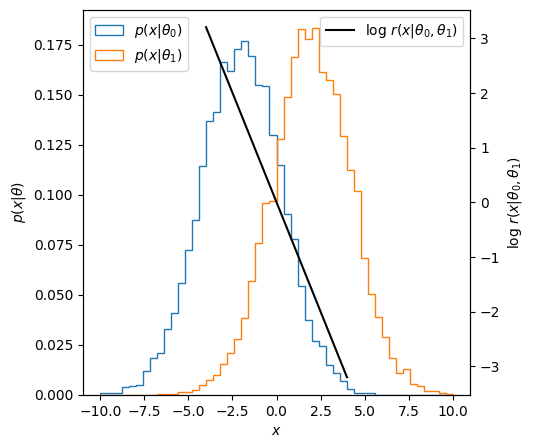

In [110]:
x0, _, _ = simulate(-2, npoints=10000)
x1, _, _ = simulate(2, npoints=10000)

xr = np.linspace(-4.0, 4.0, 100)
rx = np.log(calculate_likelihood_ratio(xr, -2, 2))

fig, ax1 = plt.subplots()
fig.set_size_inches(5, 5)
ax1.set_xlabel("$x$")
ax1.hist(x0, bins=50, range=(-10, 10.0), histtype="step", label=r"$p(x | \theta_0)$", density=True)
ax1.hist(x1, bins=50, range=(-10, 10.0), histtype="step", label=r"$p(x | \theta_1)$", density=True)
ax1.set_ylabel(r"$p(x|\theta)$")
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(xr, rx, color="black", label=r"$\log\,r(x|\theta_0,\theta_1)$")
ax2.set_ylabel(r"$\log\,r(x|\theta_0,\theta_1)$")
ax2.legend(loc=1)

plt.show()

## 2. Run the simulation and generate training data

First, we define the parameter points we want to use for training: `theta0` is uniformly distributed while the reference model `theta1` is fixed at zero. 

In [111]:
# number of parameter points to train
n_param_points = 50000

# numerator, uniform prior
theta0 = np.random.uniform(low=-4.0, high=4.0, size=n_param_points)

# denominator: fixed at 0
theta1 = np.zeros(shape=n_param_points)

We then run the simulator (one sample per parameter point). Remember that `simulate(theta, theta0, theta1, theta_score)` generates data `x` following a theory with `theta` and then evaluates the joint likelihood ratio `r(x,z|theta0,theta1)` and the join score `t(x,z|theta_score)` for each data point.

In [112]:
# Sample from theta0
x_from_theta0, r_xz_from_theta0, t_xz_from_theta0 = simulate(theta0, theta0, theta1, theta0)

# Sample from theta1
x_from_theta1, r_xz_from_theta1, t_xz_from_theta1 = simulate(theta1, theta0, theta1, theta1)

Now we combine and reshape the results (nothing interesting happening here) and save everything to files, so that we can load it later.

In [114]:
# Combine results and reshape
# x_train = np.hstack((x_from_theta0, x_from_theta1)).reshape(-1, 1)
# r_xz_train = np.hstack((r_xz_from_theta0, r_xz_from_theta1)).reshape(-1, 1)
# t_xz_train = np.hstack((t_xz_from_theta0, t_xz_from_theta1)).reshape(-1, 1)
# y_train = np.hstack((np.zeros_like(x_from_theta0), np.ones_like(np.ones_like(x_from_theta1)))).reshape(-1, 1)
# theta0_train = np.hstack((theta0, theta0)).reshape(-1, 1)
x_train = x_from_theta1
t_xz_train = t_xz_from_theta1

# Save to file
np.save("data/x_train.npy", x_train)
np.save("data/t_xz_train.npy", t_xz_train)

## 3. Model training

Let's train two neural networks to estimate the likelihood ratio. For one we use the CARL method introduced in ["Approximating Likelihood Ratios with Calibrated Discriminative Classifiers"](https://arxiv.org/abs/1506.02169), for the other the new ALICES method introduced in ["Likelihood-free inference with an improved cross-entropy estimator"](https://arxiv.org/abs/1808.00973).

In [115]:
sally = ScoreEstimator(n_hidden=(20, 20))

sally.train(
    method="sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=5,
)

sally.save("models/sally")

16:35 madminer.ml.score    INFO    Starting training
16:35 madminer.ml.score    INFO      Batch size:             128
16:35 madminer.ml.score    INFO      Optimizer:              amsgrad
16:35 madminer.ml.score    INFO      Epochs:                 5
16:35 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
16:35 madminer.ml.score    INFO      Validation split:       0.25
16:35 madminer.ml.score    INFO      Early stopping:         True
16:35 madminer.ml.score    INFO      Scale inputs:           True
16:35 madminer.ml.score    INFO      Shuffle labels          False
16:35 madminer.ml.score    INFO      Samples:                all
16:35 madminer.ml.score    INFO    Loading training data
16:35 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
16:35 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
16:35 madminer.ml.score    INFO    Found 50000 samples with 1 parameters and 1 observables
16:35 madminer.ml.base     INF

16:35 madminer.utils.ml.tr INFO      Epoch   1: train loss  0.27374 (mse_score:  0.274)
16:35 madminer.utils.ml.tr INFO                 val. loss   0.21300 (mse_score:  0.213)
16:35 madminer.utils.ml.tr INFO      Epoch   2: train loss  0.20848 (mse_score:  0.208)
16:35 madminer.utils.ml.tr INFO                 val. loss   0.20652 (mse_score:  0.207)
16:36 madminer.utils.ml.tr INFO      Epoch   3: train loss  0.20548 (mse_score:  0.205)
16:36 madminer.utils.ml.tr INFO                 val. loss   0.20496 (mse_score:  0.205)
16:36 madminer.utils.ml.tr INFO      Epoch   4: train loss  0.20470 (mse_score:  0.205)
16:36 madminer.utils.ml.tr INFO                 val. loss   0.20430 (mse_score:  0.204)
16:36 madminer.utils.ml.tr INFO      Epoch   5: train loss  0.20441 (mse_score:  0.204)
16:36 madminer.utils.ml.tr INFO                 val. loss   0.20389 (mse_score:  0.204)
16:36 madminer.utils.ml.tr INFO    Early stopping did not improve performance
16:36 madminer.utils.ml.tr INFO    Trainin

We can also try a little bit of mixing and matching -- let's train a model with CARL first and then with ALICES:

In [116]:
heteroskedastic_sally = HeteroskedasticScoreEstimator(n_hidden=(20, 20))

heteroskedastic_sally.train(
    method="heteroskedastic_sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=5,
)

heteroskedastic_sally.save("models/heteroskedastic_sally")

16:36 madminer.ml.score    INFO    Starting training
16:36 madminer.ml.score    INFO      Batch size:             128
16:36 madminer.ml.score    INFO      Optimizer:              amsgrad
16:36 madminer.ml.score    INFO      Epochs:                 5
16:36 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
16:36 madminer.ml.score    INFO      Validation split:       0.25
16:36 madminer.ml.score    INFO      Early stopping:         True
16:36 madminer.ml.score    INFO      Scale inputs:           True
16:36 madminer.ml.score    INFO      Shuffle labels          False
16:36 madminer.ml.score    INFO      Samples:                all
16:36 madminer.ml.score    INFO    Loading training data
16:36 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
16:36 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
16:36 madminer.ml.score    INFO    Found 50000 samples with 1 parameters and 1 observables
16:36 madminer.ml.base     INF

16:36 madminer.utils.ml.tr INFO      Epoch   1: train loss -0.15238 (heteroskedastic_loss: -0.152)
16:36 madminer.utils.ml.tr INFO                 val. loss  -0.28646 (heteroskedastic_loss: -0.286)
16:36 madminer.utils.ml.tr INFO      Epoch   2: train loss -0.28822 (heteroskedastic_loss: -0.288)
16:36 madminer.utils.ml.tr INFO                 val. loss  -0.29250 (heteroskedastic_loss: -0.293)
16:37 madminer.utils.ml.tr INFO      Epoch   3: train loss -0.29258 (heteroskedastic_loss: -0.293)
16:37 madminer.utils.ml.tr INFO                 val. loss  -0.29539 (heteroskedastic_loss: -0.295)
16:37 madminer.utils.ml.tr INFO      Epoch   4: train loss -0.29468 (heteroskedastic_loss: -0.295)
16:37 madminer.utils.ml.tr INFO                 val. loss  -0.29617 (heteroskedastic_loss: -0.296)
16:37 madminer.utils.ml.tr INFO      Epoch   5: train loss -0.29542 (heteroskedastic_loss: -0.295)
16:37 madminer.utils.ml.tr INFO                 val. loss  -0.29686 (heteroskedastic_loss: -0.297)
16:37 madm

In [117]:
bayes_sally = BayesianScoreEstimator(n_hidden=(20, 20))

bayes_sally.train(
    method="bayesian_sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=5,
)

bayes_sally.save("models/bayes_sally")

16:37 madminer.ml.score    INFO    Starting training
16:37 madminer.ml.score    INFO      Batch size:             128
16:37 madminer.ml.score    INFO      Optimizer:              amsgrad
16:37 madminer.ml.score    INFO      Epochs:                 5
16:37 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
16:37 madminer.ml.score    INFO      Validation split:       0.25
16:37 madminer.ml.score    INFO      Early stopping:         True
16:37 madminer.ml.score    INFO      Scale inputs:           True
16:37 madminer.ml.score    INFO      Shuffle labels          False
16:37 madminer.ml.score    INFO      Samples:                all
16:37 madminer.ml.score    INFO    Loading training data
16:37 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
16:37 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
16:37 madminer.ml.score    INFO    Found 50000 samples with 1 parameters and 1 observables
16:37 madminer.ml.base     INF

16:37 madminer.utils.ml.tr INFO      Epoch   1: train loss 14.29054 (bayesian_loss: 14.291)
16:37 madminer.utils.ml.tr INFO                 val. loss  13.82060 (bayesian_loss: 13.821)
16:37 madminer.utils.ml.tr INFO      Epoch   2: train loss 13.56371 (bayesian_loss: 13.564)
16:37 madminer.utils.ml.tr INFO                 val. loss  13.45989 (bayesian_loss: 13.460)
16:37 madminer.utils.ml.tr INFO      Epoch   3: train loss 13.29971 (bayesian_loss: 13.300)
16:37 madminer.utils.ml.tr INFO                 val. loss  13.27760 (bayesian_loss: 13.278)
16:37 madminer.utils.ml.tr INFO      Epoch   4: train loss 13.15812 (bayesian_loss: 13.158)
16:37 madminer.utils.ml.tr INFO                 val. loss  13.17635 (bayesian_loss: 13.176)
16:38 madminer.utils.ml.tr INFO      Epoch   5: train loss 13.07969 (bayesian_loss: 13.080)
16:38 madminer.utils.ml.tr INFO                 val. loss  13.11847 (bayesian_loss: 13.118)
16:38 madminer.utils.ml.tr INFO    Early stopping did not improve performance
16

## 5. Evaluation

It's time to evaluate our likelihood ratio estimators!

This is the expected log likelihood ratio over parameter space:

## Score evaluation

In [118]:
n_param_points_test = 1000  # number of parameter points to test
theta_test = 0.0 * np.zeros(shape=n_param_points_test).reshape(-1, 1)

In [119]:
x_test, _, _ = simulate(theta_test)
x_test = np.sort(x_test, axis=0)

np.save("data/x_test.npy", x_test)

In [120]:
sally = ScoreEstimator()
sally.load("models/sally")

t_hat_sally = sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)

16:38 madminer.ml.base     INFO    Loading model from models/sally
16:38 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


In [121]:
bayes_sally = BayesianScoreEstimator()
bayes_sally.load("models/bayes_sally")

t_hat_bayes_sally, t_hat_sig_bayes_sally = bayes_sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)
t_hat_bayes_sally = t_hat_bayes_sally.flatten()
t_hat_sig_bayes_sally = t_hat_sig_bayes_sally.flatten()
t_hat_sig_bayes_sally = np.sqrt(t_hat_sig_bayes_sally)

16:38 madminer.ml.base     INFO    Loading model from models/bayes_sally
16:38 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


In [122]:
heteroskedastic_sally = HeteroskedasticScoreEstimator()
heteroskedastic_sally.load("models/heteroskedastic_sally")

t_hat_heteroskedastic_sally, t_hat_sig_heteroskedastic_sally = heteroskedastic_sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)
t_hat_heteroskedastic_sally = t_hat_heteroskedastic_sally.flatten()
t_hat_sig_heteroskedastic_sally = t_hat_sig_heteroskedastic_sally.flatten()
t_hat_sig_heteroskedastic_sally = np.sqrt(t_hat_sig_heteroskedastic_sally)

16:38 madminer.ml.base     INFO    Loading model from models/heteroskedastic_sally
16:38 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


In [123]:
def calculate_true_score(x, theta):
    combined_std = (z_std**2 + x_std**2) ** 0.5
    r_x = 2*(x - theta)/combined_std**2
    return r_x

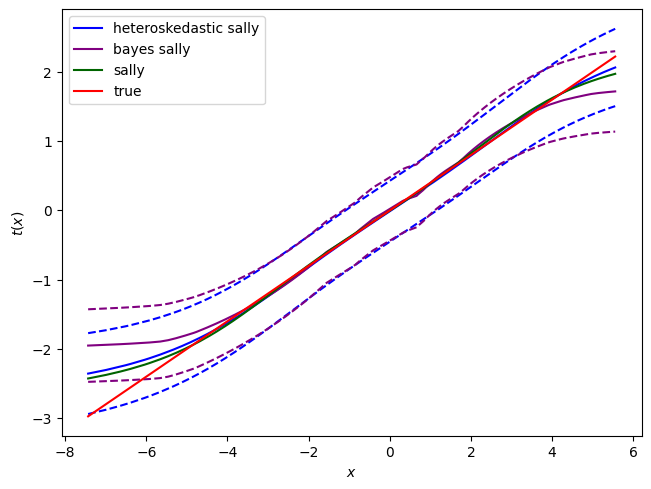

In [124]:
x = np.load("data/x_test.npy")
x = np.sort(x)
t_hat_true = calculate_true_score(x, 0)

fig = plt.figure()

plt.plot(x, t_hat_heteroskedastic_sally,                                   c='b', label='heteroskedastic sally')
plt.plot(x, t_hat_heteroskedastic_sally - t_hat_sig_heteroskedastic_sally, c='b', ls='--')
plt.plot(x, t_hat_heteroskedastic_sally + t_hat_sig_heteroskedastic_sally, c='b', ls='--')
plt.plot(x, t_hat_bayes_sally,                         c='purple', label='bayes sally')
plt.plot(x, t_hat_bayes_sally + t_hat_sig_bayes_sally, c='purple', ls='--')
plt.plot(x, t_hat_bayes_sally - t_hat_sig_bayes_sally, c='purple', ls='--')
plt.plot(x, t_hat_sally.flatten(), c='darkgreen', label='sally')
plt.plot(x, t_hat_true, c='r', label='true')

plt.legend()

plt.tight_layout()
plt.xlabel(r"$x$")
plt.ylabel(r"$t(x)$")
plt.show()